## Plan
1. Train classifier and evaluate performance (logistic regression, random forests, Naive Bayes).
2. Model selection (hyperparameter tuning).
3. Interpretation of results.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [14]:
# Add higher directory to python modules path.

import sys
sys.path.append("..")

In [15]:
# Local utility functions
from utilities import machine_learning_utils
#import importlib
#importlib.reload(machine_learning_utils)

****

In [16]:
import pickle

X_train,y_train,X_test,y_test,feature_names,words_train_df = pickle.load(open("../../generated_data/word_data_features.p","rb"))
X_train.shape,X_test.shape,feature_names.shape, words_train_df.shape

((35761, 3000), (11921, 3000), (3000,), (35761, 2))

In [17]:
# save original variables just in case
X_train0,y_train0 = X_train,y_train

In [18]:
pd.Series(y_train).value_counts()

MSA    35171
TN       590
dtype: int64

*****

## Build classification model

### Baseline Random Classifier

In [19]:
n = X_test.shape[0]
np.random.seed(123)
y_test_pred_rand = np.asarray(["MSA" if x==0 else "TN" for x in np.random.binomial(n=1,p=0.5,size=n)])

In [20]:
print(metrics.classification_report(y_test,y_test_pred_rand))

              precision    recall  f1-score   support

         MSA       0.98      0.50      0.66     11724
          TN       0.02      0.49      0.03       197

   micro avg       0.50      0.50      0.50     11921
   macro avg       0.50      0.49      0.35     11921
weighted avg       0.97      0.50      0.65     11921



In [21]:
# The average F1 score for the two classes
u = pd.DataFrame(metrics.classification_report(y_test,y_test_pred_rand,output_dict=True))
u.loc["f1-score",["MSA","TN"]].mean()

0.3451274038584584

### Logistic Regression

In [22]:
LR_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**Remark**: About hyperparameters of the logistic regression model

*penalty* and *C* are both related to regularization.

- *penalty*: Used to specify the norm used in the regularization term in the cost function. 

- *C*: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

TO DO: Should probably tune these hyperparameters via cross-valdiation.

In [23]:
# Use this model to predict the category of words
y_test_pred_LR = LR_model.predict(X_test)
prob_test_pred_LR = LR_model.predict_proba(X_test)

------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.98      1.00      0.99     11724
          TN       0.80      0.02      0.04       197

   micro avg       0.98      0.98      0.98     11921
   macro avg       0.89      0.51      0.52     11921
weighted avg       0.98      0.98      0.98     11921

Average F1 score: 0.5156987653080028

Confusion matrix:
col_0    MSA  TN
row_0           
MSA    11723   1
TN       193   4


------------------------------------
Area Under the Curve:  0.910
------------------------------------



------------------------------------
Maximum F1 Scores:
------------------------------------
                MSA        TN   Average
Threshold  0.224699  0.088159  0.088159
Max(F1)    0.991993  0.375321  0.682459

------------------------------------



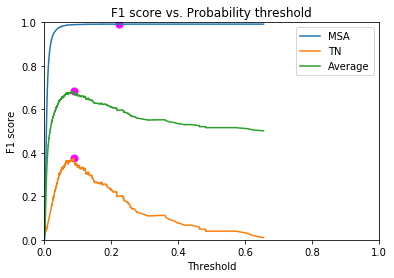

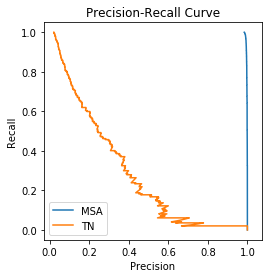

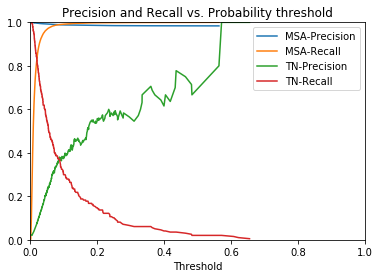

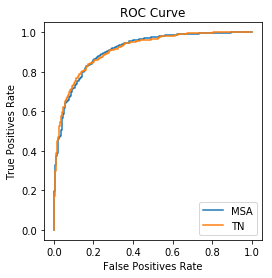

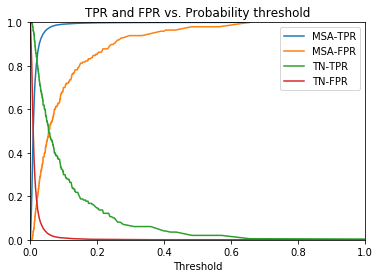

In [24]:
machine_learning_utils.my_performance_report(y_test,y_test_pred_LR,prob_test_pred_LR,LR_model.classes_)

#### Analyze feature weights (coefficients)

In [25]:
feat_imp_LR = LR_model.coef_.ravel()  ## Coefficient of the features in the decision function.
assert(len(feat_imp_LR) == X_train.shape[1])
type(feat_imp_LR),feat_imp_LR.shape

(numpy.ndarray, (3000,))

Top 10 Features:
Importance_score	Ngram_feature
      6.309		"و "
      3.927		"ش "
      3.135		"اي"
      2.760		"ك "
      2.696		" ما"
      2.567		" را"
      2.545		" ه"
      2.531		" بر"
      2.213		"اا"
      2.177		" ز"

feature: "و "

Number of training words that contain this feature: 335

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                   251  35171    0.713656
TN                     84    590   14.237288

Example training words that contain this feature:
  MSA: ['دييغو', 'مونشو', 'ألفونسو', 'اليونسكو', 'دو', 'اللهو', 'فانواتو', 'للنمو', 'العدو', 'ميناموتو']
  TND: []

feature: "ش "

Number of training words that contain this feature: 203

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                   162  35171    0.460607
TN                     41    590    6.949153

Example training words that contain this feature:


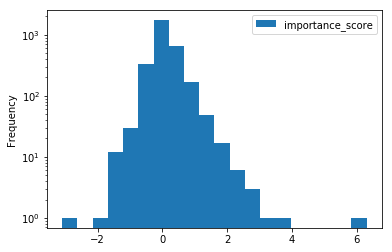

In [26]:
machine_learning_utils.analyze_feature_importance(feat_imp_LR,feature_names,words_train_df,X_train)

### Naive Bayes

In [27]:
#?MultinomialNB

In [28]:
NB_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
NB_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Remark: **

*alpha* is an additive (Laplace/Lidstone) smoothing parameter, 0 for no smoothing, 1 for maximal smooting. 

It is an important hyperparameter that should probably be tweaked via cross-validation.

In [29]:
y_test_pred_NB = NB_model.predict(X_test)
prob_test_pred_NB = NB_model.predict_proba(X_test)

------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.98      1.00      0.99     11724
          TN       0.00      0.00      0.00       197

   micro avg       0.98      0.98      0.98     11921
   macro avg       0.49      0.50      0.50     11921
weighted avg       0.97      0.98      0.98     11921

Average F1 score: 0.49583421442165365

Confusion matrix:
col_0    MSA
row_0       
MSA    11724
TN       197


------------------------------------


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Area Under the Curve:  0.885
------------------------------------



------------------------------------
Maximum F1 Scores:
------------------------------------
                MSA        TN   Average
Threshold  0.216150  0.053080  0.067001
Max(F1)    0.992045  0.315522  0.652688

------------------------------------



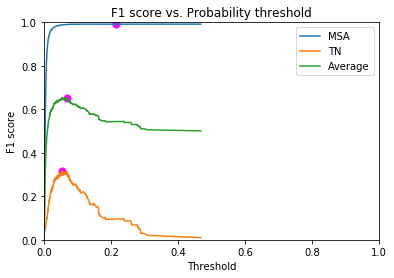

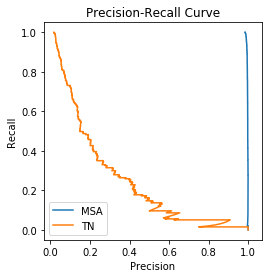

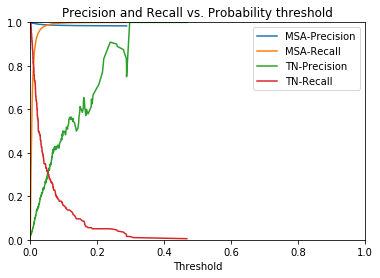

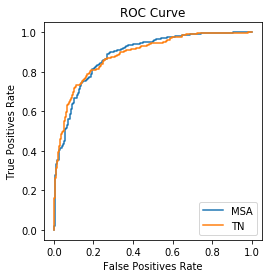

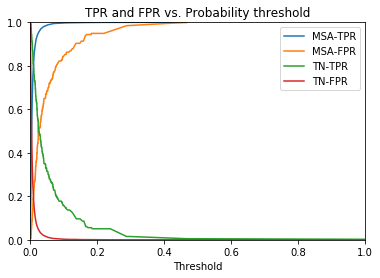

In [30]:
machine_learning_utils.my_performance_report(y_test,y_test_pred_NB,prob_test_pred_NB,NB_model.classes_)

#### Analyze feature probabilities

In [31]:
feat_imp_NB = NB_model.coef_  
type(feat_imp_NB),feat_imp_NB.shape

(numpy.ndarray, (1, 3000))

In [32]:
# Empirical log probability of features given a class
p = NB_model.feature_log_prob_
assert(np.all(feat_imp_NB == p[1,:]))
type(p),p.shape

(numpy.ndarray, (2, 3000))

Top 10 Features:
Importance_score	Ngram_feature
     -5.213		"و"
     -5.224		"ي"
     -5.272		"و "
     -5.430		"م"
     -5.569		"ه"
     -5.619		"ش"
     -5.633		"ك"
     -5.648		" م"
     -5.700		"ل"
     -5.729		"ا "

feature: "و"

Number of training words that contain this feature: 10901

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                 10699  35171   30.419948
TN                    202    590   34.237288

Example training words that contain this feature:
  MSA: ['ومعنوية', 'ووضعوا', 'حكومته', 'ووقت', 'بيوتنا', 'والرقص', 'اليومين', 'بالحيوية', 'الهوى', 'والمشاركة']
  TND: []

feature: "ي"

Number of training words that contain this feature: 11916

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                 11704  35171   33.277416
TN                    212    590   35.932203

Example training words that contain this feature:
 

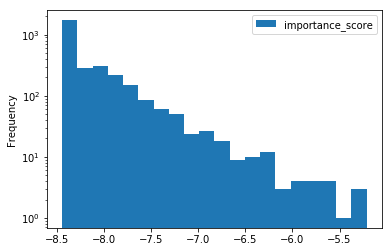

In [33]:
feat_imp_NB = feat_imp_NB.ravel()
machine_learning_utils.analyze_feature_importance(feat_imp_NB,feature_names,words_train_df,X_train)

### Random Forests

In [34]:
# ?RandomForestClassifier

#### 1D Hyperparameter Search
- number of estimators (trees)

In [35]:
n_estimators_values = list(range(100,1001,50))
RF_param_grid = dict(n_estimators=n_estimators_values)

# size of the grid
len(n_estimators_values)

19

In [36]:
## Commented out for now because takes too long to run

if False:
    grid_search_obj = GridSearchCV(RandomForestClassifier(random_state=123), RF_param_grid, cv=10, scoring='roc_auc', return_train_score=False)
    grid_search_obj.fit(X_train, y_train)
    print(pd.DataFrame(grid_search_obj.cv_results_['params']).head())
    grid_mean_scores = grid_search_obj.cv_results_['mean_test_score']
    plt.plot(n_estimators_values,grid_mean_scores)
    plt.xlabel('Number of trees')
    plt.ylabel('Performance metric')

#### 2D hyperparameter search
- number of estimators (trees)
- maximum tree depth

In [37]:
## Commented out temporarily because takes too long to run

if False:
    n_estimators_values = list(range(100,1001,50))
    max_depth_values = list(range(1,20,5)) + [None]
    RF_param_grid2 = dict(n_estimators=n_estimators_values, max_depth=max_depth_values)

    # size of the grid
    print(len(n_estimators_values),len(max_depth_values))

    grid_search_obj2 = GridSearchCV(RandomForestClassifier(random_state=123), RF_param_grid2, cv=10, scoring='roc_auc', return_train_score=False)
    grid_search_obj2.fit(X_train, y_train)

    df1 = pd.DataFrame(grid_search_obj2.cv_results_)[['mean_test_score', 'std_test_score']]
    df2 = pd.DataFrame(grid_search_obj2.cv_results_['params'])
    res_df = pd.concat([df1,df2],axis=1)
    res_df = res_df.set_index(['max_depth','n_estimators'])
    res_df.pivot_table(index='max_depth', values='mean_test_score', aggfunc='max')
    res_df.pivot_table(index='n_estimators', values='mean_test_score', aggfunc='max')
    grid_mean_scores = grid_search_obj2.cv_results_['mean_test_score']

    plt.plot(grid_mean_scores)
    plt.xlabel('Run number')
    plt.ylabel('Performance metric')
    plt.show()
    # TO DO: heatmap of performance vs. number of trees and max_depth


#### Train RF model with chosen hyperparameter value

In [38]:
RF_model = RandomForestClassifier(n_estimators = 400, random_state = 123)
RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [39]:
y_test_pred_RF = RF_model.predict(X_test)
prob_test_pred_RF = RF_model.predict_proba(X_test)
y_test_pred_RF.shape,prob_test_pred_RF.shape

((11921,), (11921, 2))

------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.98      1.00      0.99     11724
          TN       0.36      0.05      0.09       197

   micro avg       0.98      0.98      0.98     11921
   macro avg       0.67      0.52      0.54     11921
weighted avg       0.97      0.98      0.98     11921

Average F1 score: 0.5401043504443598

Confusion matrix:
col_0    MSA  TN
row_0           
MSA    11706  18
TN       187  10


------------------------------------
Area Under the Curve:  0.887
------------------------------------



------------------------------------
Maximum F1 Scores:
------------------------------------
               MSA        TN   Average
Threshold  0.70000  0.127500  0.127500
Max(F1)    0.99171  0.332203  0.657697

------------------------------------



..\utilities\machine_learning_utils.py:23: RuntimeWarning: invalid value encountered in true_divide
  return 2 * (precision * recall) / (precision + recall)


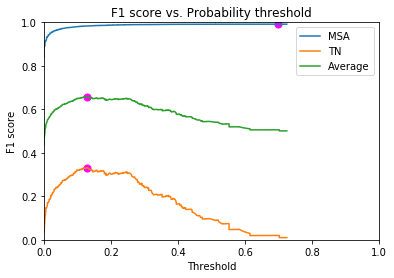

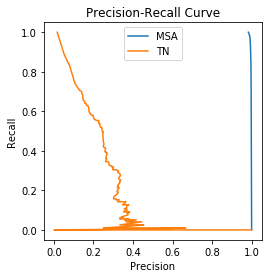

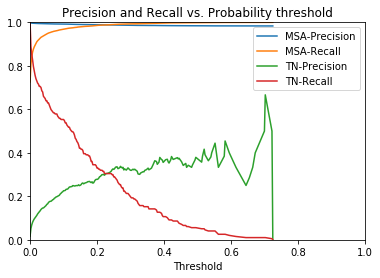

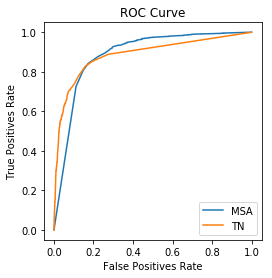

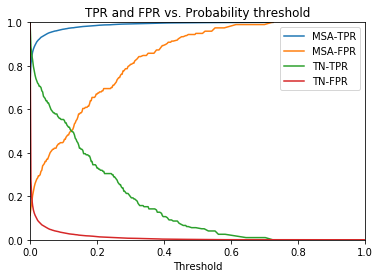

In [40]:
machine_learning_utils.my_performance_report(y_test,y_test_pred_RF,prob_test_pred_RF,RF_model.classes_)

#### Analyze feature importance

In [41]:
feat_imp_RF = RF_model.feature_importances_  
type(feat_imp_RF),feat_imp_RF.shape

(numpy.ndarray, (3000,))

Top 10 Features:
Importance_score	Ngram_feature
      0.019		"و "
      0.011		"ي"
      0.011		"و"
      0.010		"م"
      0.009		"ل"
      0.008		"ه"
      0.007		"ش "
      0.007		"ر"
      0.006		"ك"
      0.006		"ا "

feature: "و "

Number of training words that contain this feature: 335

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                   251  35171    0.713656
TN                     84    590   14.237288

Example training words that contain this feature:
  MSA: ['دييغو', 'مونشو', 'ألفونسو', 'اليونسكو', 'دو', 'اللهو', 'فانواتو', 'للنمو', 'العدو', 'ميناموتو']
  TND: []

feature: "ي"

Number of training words that contain this feature: 11916

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                 11704  35171   33.277416
TN                    212    590   35.932203

Example training words that contain this feature:
  MSA: ['

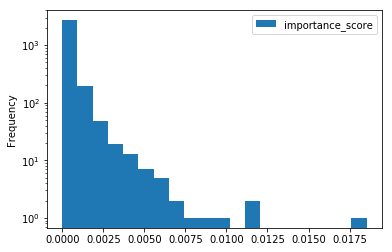

In [42]:
machine_learning_utils.analyze_feature_importance(feat_imp_RF,feature_names,words_train_df,X_train)

****

**Remark**:  About posterior class probabilities and threshold calibration

- The `predict_proba`() method calculates/returns posterior probabilities of each class $c$ given the input data $x$ (i.e. $\Pr(c|x)$).
- The output class for any data $x$ is the one with the larger posterior probability. For binary classification, this is equivalent to the threshold-based decision function with threshold=0.5. This is exactly what the ``predict``() method implements.  
- This decision function basically optimizes classification accuracy, which is not an appropriate metric when the classes are either quite imbalanced in the training data (which is the case for our data), and/or the classes do not have equal importance in the real-life cost function (making an error in one class costs much more than in the other class).
- In this case, we cannot rely on the results of `predict`. We should instead **calibrate** the value of the threshold, i.e determine the value that optimizes performance (instead of the default value 0.5), as well as use a different performance metric that is more suitable for imbalanced data, such as F1 score.
- It also helps to plot ROC and Precision-Recall curves, and then visually identify optimal operating points (threshold value) on these curves.


From the docstring of `predict()` for random forests:
*"The predicted class of an input sample is a vote by the trees in
the forest, weighted by their probability estimates. That is,
the predicted class is the one with highest mean probability
estimate across the trees."*

From docstring of `predict_proba` for random forests: *The predicted class probabilities of an input sample are computed as the mean predicted class probabilities of the trees in the forest. The
class probability of a single tree is the fraction of samples of the same
class in a leaf.*

**TO DO**: create a custom *predict* method that uses probabilities and the calibrated threshold.

****

**Final Remarks and Conclusions**

- All three methods (logistic regression, Naive Bayes, and Random Forests) achieved comparable best performance, with Logistic Regression slightly edging out the other two at an AUC of 0.85 and an average F1 score of 0.73 (0.45 for the TD class and 0.95 for the MSA class). Logistic Regression also seems to do a better job at selecting the 'right' features (see analysis above).
- Performance is obviously quite **biased** towards the MSA class since the training set contains more than 10 times MSA samples than TD samples (around 10K MSA samples vs. around 550 TD samples, as shown below).
- We have only tried to deal with the **data imbalance** problem in the decision function by calibrating the probability threshold value.
- Another approach for the data imbalance problem is to bias the model fitting process towards the minority class. There are many ways to do that: i) by undersampling the majority class, ii) oversampling the minority class, or iii) by using a modified loss function in which the minority class errors are penalized more heavily. We'll explore some of these alternatives in the next part.


In [44]:
# class imbalance in training data
pd.Series(y_train).value_counts()

MSA    35171
TN       590
dtype: int64